# In Context Learning with Gemma 3

> Predict rule violations via Few Shot prompting

In [1]:
import kagglehub
import pandas as pd
import torch

from datasets import Dataset, load_dataset
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.notebook import tqdm


COMPETITION_HANDLE = "jigsaw-agile-community-rules"

GEMMA_1B_IT_HANDLE = "google/gemma-3/transformers/gemma-3-1b-it"
GEMMA_4B_IT_HANDLE = "google/gemma-3/transformers/gemma-3-4b-it"
GEMMA_4B_IT_Q4_HANDLE = "google/gemma-3/transformers/gemma-3-4b-it-qat-q4_0-unquantized"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


## Downloading Data and Models

In [2]:
DATA_PATH = Path(kagglehub.competition_download(COMPETITION_HANDLE))

print(DATA_PATH)

/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules


In [3]:
TRAIN_PATH = DATA_PATH / "train.csv"
TEST_PATH = DATA_PATH / "test.csv"
SAMPLE_PATH = DATA_PATH / "sample_submission.csv"


train_df = pd.read_csv(TRAIN_PATH, index_col=0)
test_df = pd.read_csv(TEST_PATH, index_col=0)
sample_df = pd.read_csv(SAMPLE_PATH, index_col=0)

In [4]:
GEMMA_1B_IT_PATH = Path(kagglehub.model_download(GEMMA_1B_IT_HANDLE))
print(GEMMA_1B_IT_PATH)

/root/.cache/kagglehub/models/google/gemma-3/transformers/gemma-3-1b-it/1


## Loading gemma-3

The AutoModel and AutoTokenizer classes will automatically select the right Model and Tokenizer class for our pretrained model.
I.e., they will resolve to `Gemma3ForCausalLM` and `GemmaTokenizerFast`.

In [5]:
model = AutoModelForCausalLM.from_pretrained(GEMMA_1B_IT_PATH)

# move model to GPU if available
model.to(DEVICE)

print(type(model))

<class 'transformers.models.gemma3.modeling_gemma3.Gemma3ForCausalLM'>


In [6]:
tokenizer = AutoTokenizer.from_pretrained(GEMMA_1B_IT_PATH)
print(type(tokenizer))

<class 'transformers.models.gemma.tokenization_gemma_fast.GemmaTokenizerFast'>


## Prompting gemma-3 via Transformers

In [7]:
# try out the llm
prompt = "Do you like Bratwurst?"

In [8]:
# apply tokenizer: cut string into tokens and map to token ids
input_ids = tokenizer.encode(prompt, return_tensors="pt")
input_ids

tensor([[     2,   6294,    611,   1133,  70383, 236765,  69123, 236881]])

In [9]:
# apply our model to generate output ids
output_ids = model.generate(input_ids.to(DEVICE))
output_ids

tensor([[     2,   6294,    611,   1133,  70383, 236765,  69123, 236881,    108,
         236769,  10784, 236786,   3771, 236768,    108,   2859,    611,  19398,
            623,   3771,   2098,   1299,   5091,   3442,    786,   3217, 236761,
            108]], device='cuda:0')

In [10]:
# decode output token ids
tokenizer.batch_decode(output_ids)

['<bos>Do you like Bratwurst?\n\n(Yes/No)\n\nIf you answered "No," then please tell me why.\n\n']

In [11]:
# you can use a pipeline object to simplify the prompting
from transformers.pipelines import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


## Using an instruction tuned (it) model

In [12]:
# however, we want the llm to answer our question (like ChatGPT) instead of just elaborating on it
# first of all, we need an instruction tuned (it) model
# then, we need to apply the chat template
chat = [
    { "role": "user", "content": prompt},
]

messages = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

print(messages)

<bos><start_of_turn>user
Do you like Bratwurst?<end_of_turn>
<start_of_turn>model



In [13]:
pipe(messages, max_new_tokens=50, return_full_text=False)

[{'generated_text': "As a large language model, I don't have taste buds or the ability to enjoy food! But… I can definitely tell you that Bratwurst is a *very* popular and delicious food in Germany and Austria. It’s a classic"}]

### Prompting the model to predict rule violations

In [14]:
# this will be our prompt template that we can fill with values from our data frame
template = """
You are a very serious and hard-working reddit mod from the {subreddit} subreddit and need to flag comments if they violate the following rule:
{rule}

Answer only with 'True', if they violate the rule, otherwise answer only with 'False'. Omit everything else.
Here are some examples to get you started:

# Example 1

Comment: {positive_example_1}
Output: True

# Example 2

Comment: {positive_example_2}
Output: True

# Example 3

Comment: {negative_example_1}
Output: False

# Example 4

Comment: {negative_example_2}
Output: False

# Test

Now it's your turn!

Comment: {body}
Output:
"""

In [15]:
def apply_template(**kwargs):
    """Utility function that applies our chat template."""
    global template, tokenizer

    content = template.format(**kwargs)

    chat = [
        { "role": "user", "content": content},
    ]

    messages = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

    return messages 

In [16]:
def predict_rows(df: pd.DataFrame):
    """Sequential Prediction for demonstration - would be faster to use a transformer's Dataset."""
    global tokenizer, template, pipe
    outputs = []
    total = len(df)
    for row_id, row in tqdm(df.iterrows(), total=total):
        messages = apply_template(**row)
        # cut off model after generating 1 token (True or False)
        output = pipe(messages, max_new_tokens=1, return_full_text=False)
        output = output[0]["generated_text"]
        outputs.append(output)
    return pd.DataFrame({"rule_violation": outputs}, index=df.index)

## How well does it perform on the train set?

In [17]:
x_train = train_df.drop(columns="rule_violation")
# convert labels to "True" / "False" Strings
y_train = train_df["rule_violation"].astype(bool).astype(str)

In [18]:
pred_train_df = predict_rows(x_train)
pred_train = pred_train_df["rule_violation"]

  0%|          | 0/2029 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


<Axes: title={'center': 'few shot train predictions'}, xlabel='rule_violation'>

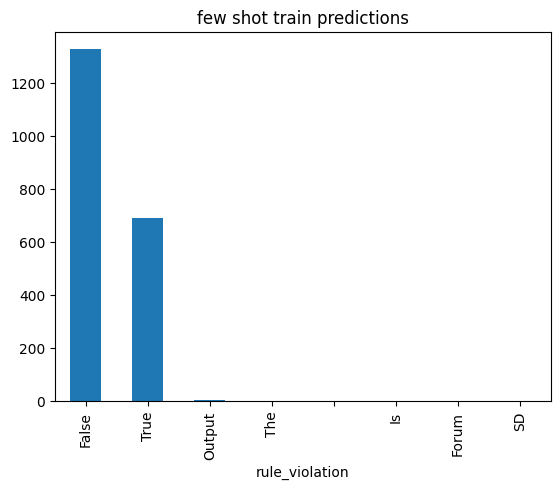

In [19]:
# did the model actually only predict False and True?
pred_train.value_counts().plot.bar(title="few shot train predictions")

In [20]:
acc_train = (y_train == pred_train).mean()

print(f"train accuracy: {100 * acc_train:.2f} %")

train accuracy: 51.16 %


## Test Set Predictions

In [21]:
submission_df = predict_rows(test_df)
submission_df["rule_violation"] = submission_df["rule_violation"].map({
    "True": 1,
    "False": 0
}).fillna(0.5)

submission_df.to_csv("submission.csv")
submission_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

,rule_violation
row_id,
2029,0
2030,0
2031,0
2032,0
2033,0


## Bookmarks

- kaggle:
    - https://github.com/Kaggle/kagglehub
    - https://www.kaggle.com/models
    - https://www.kaggle.com/models/google/gemma-3/transformers/gemma-3-1b-it